In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 데이터 불러오기

In [72]:
cifar100 = torchvision.datasets.CIFAR100(root='./data', 
                                         train=True, 
                                         download=True)

Files already downloaded and verified


# 데이터 분할하기

In [ ]:
# 7 : 1.5 : 1.5

In [73]:
cifar100.data.shape

(50000, 32, 32, 3)

In [75]:
train_x, test_val_x_sub, train_y, test_val_y_sub= train_test_split(cifar100.data, cifar100.targets, test_size=0.3)

In [76]:
val_x, test_x, val_y, test_y = train_test_split(test_val_x_sub, test_val_y_sub, test_size=0.5)

In [77]:
len(train_y), len(val_y), len(test_y)

(35000, 7500, 7500)

In [ ]:
import matplotlib.pyplot as plt

img = train_x[0]

plt.imshow(img)
plt.xlabel(train_y[0])

# 데이터 전처리

In [78]:
from torchvision import transforms

train_transform = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)), # 평균, 표준편차
])

test_transform = transforms.Compose([
#     transforms.Resize(32, 32),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
])

# 데이터셋 & 데이터 로더 생성 

In [79]:
from PIL import Image

class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform):
        self.transform = transform
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        # numpy 배열을 PIL 이미지로 변환
        x = Image.fromarray(self.x[index])
        # 변환 적용
        x = self.transform(x)
        y = self.y[index]
        
        return x, y

In [80]:
train_ds = custom_dataset(train_x, train_y, train_transform)
test_ds = custom_dataset(test_x, test_y, test_transform)
val_ds = custom_dataset(val_x, val_y, test_transform)
print(train_ds)
# print(train_ds.__len__())
# print(test_ds.__len__())
# print(val_ds.__len__())
# print(train_ds.__getitem__(0))
# print(test_ds.__getitem__(0))
# print(val_ds.__getitem__(0))

In [203]:
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True,)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=32)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=32)


# 모델 구성

In [204]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 32, 32]) torch.Size([32])


In [402]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        self.batchnorm2= nn.BatchNorm2d(num_features=64)
        self.batchnorm3 = nn.BatchNorm2d(num_features=128)
        self.batchnorm4 = nn.BatchNorm2d(num_features=256)
        self.dropout = nn.Dropout(p=0.3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear = nn.Linear(2 * 2 * 256, 100)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        # x = self.dropout(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(-1, 2 * 2 * 256)
        x = self.dropout(x)
        x = self.linear(x)

        return x

In [403]:
model = cnn().to(device)
print(model)

cnn(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=1024, out_features=100, bias=True)
)


In [404]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)

In [405]:
from sklearn.metrics import accuracy_score
import tqdm

def train_validate(model, train_dataloader, test_loader, optimizer, loss_func, epochs):
    train_losses = []
    train_accs = []
    validation_losses = []
    validation_accs = []

    for epoch in range(epochs):
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        model.train()

        # 훈련 루프
        for data, target in tqdm.tqdm(train_dataloader):
            
            data = data.to(device)
            target = target.to(device)

            y_pred = model(data)

            loss = criterion(y_pred, target)

            acc = accuracy_score(target.cpu(), y_pred.argmax(dim=1).detach().cpu())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            epoch_train_acc += acc

        # 에포크 당 평균 훈련 손실 및 정확도
        avg_train_loss = epoch_train_loss / len(train_dataloader)
        avg_train_acc = epoch_train_acc / len(train_dataloader)

        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)

        print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")

        # 검증 루프
        model.eval()
        epoch_validation_loss = 0.0
        with torch.no_grad():
            for data, target in tqdm.tqdm(test_loader):
                
                data = data.to(device)
                target = target.to(device)

                y_pred = model(data)

                loss = loss_func(y_pred, target)

                epoch_validation_loss += loss.item()
        
        avg_validation_loss = epoch_validation_loss / len(test_loader)
        avg_validation_acc = accuracy_score(target.cpu(), y_pred.argmax(dim=1).detach().cpu())
        
        validation_losses.append(avg_validation_loss)
        validation_accs.append(avg_validation_acc)

        print(f"Validation Loss: {avg_validation_loss:.4f}, Validation Acc: {avg_validation_acc:.4f} \n")

    return train_losses, train_accs, validation_losses, validation_accs

In [406]:
epochs=20

In [407]:
train_losses, train_accs, validation_losses, validation_accs = train_validate(model, train_dataloader, val_dataloader, optimizer, criterion, epochs)

100%|██████████| 1093/1093 [00:13<00:00, 80.26it/s]


Epoch: 1, Train Loss: 3.5620, Train Acc: 0.1668


100%|██████████| 235/235 [00:01<00:00, 122.79it/s]


Validation Loss: 2.9315, Validation Acc: 0.3333 



100%|██████████| 1093/1093 [00:13<00:00, 79.03it/s]


Epoch: 2, Train Loss: 2.7078, Train Acc: 0.3136


100%|██████████| 235/235 [00:01<00:00, 136.42it/s]


Validation Loss: 2.4528, Validation Acc: 0.4167 



100%|██████████| 1093/1093 [00:13<00:00, 82.11it/s]


Epoch: 3, Train Loss: 2.3339, Train Acc: 0.3883


100%|██████████| 235/235 [00:01<00:00, 125.66it/s]


Validation Loss: 2.2814, Validation Acc: 0.2500 



100%|██████████| 1093/1093 [00:13<00:00, 79.51it/s]


Epoch: 4, Train Loss: 2.0910, Train Acc: 0.4406


100%|██████████| 235/235 [00:01<00:00, 122.35it/s]


Validation Loss: 2.1440, Validation Acc: 0.5000 



100%|██████████| 1093/1093 [00:13<00:00, 78.48it/s]


Epoch: 5, Train Loss: 1.9057, Train Acc: 0.4862


100%|██████████| 235/235 [00:01<00:00, 124.38it/s]


Validation Loss: 2.0925, Validation Acc: 0.4167 



100%|██████████| 1093/1093 [00:13<00:00, 79.27it/s]


Epoch: 6, Train Loss: 1.7474, Train Acc: 0.5231


100%|██████████| 235/235 [00:01<00:00, 129.32it/s]


Validation Loss: 1.9895, Validation Acc: 0.4167 



100%|██████████| 1093/1093 [00:14<00:00, 77.51it/s]


Epoch: 7, Train Loss: 1.6066, Train Acc: 0.5564


100%|██████████| 235/235 [00:01<00:00, 126.64it/s]


Validation Loss: 1.9844, Validation Acc: 0.3333 



100%|██████████| 1093/1093 [00:13<00:00, 78.40it/s]


Epoch: 8, Train Loss: 1.4882, Train Acc: 0.5857


100%|██████████| 235/235 [00:01<00:00, 119.13it/s]


Validation Loss: 1.9884, Validation Acc: 0.5000 



100%|██████████| 1093/1093 [00:13<00:00, 78.29it/s]


Epoch: 9, Train Loss: 1.3868, Train Acc: 0.6104


100%|██████████| 235/235 [00:01<00:00, 127.34it/s]


Validation Loss: 1.9284, Validation Acc: 0.3333 



100%|██████████| 1093/1093 [00:13<00:00, 78.87it/s]


Epoch: 10, Train Loss: 1.2905, Train Acc: 0.6337


100%|██████████| 235/235 [00:01<00:00, 132.31it/s]


Validation Loss: 1.9538, Validation Acc: 0.5000 



100%|██████████| 1093/1093 [00:13<00:00, 80.03it/s]


Epoch: 11, Train Loss: 1.2134, Train Acc: 0.6522


100%|██████████| 235/235 [00:01<00:00, 132.66it/s]


Validation Loss: 1.9490, Validation Acc: 0.4167 



100%|██████████| 1093/1093 [00:13<00:00, 78.46it/s]


Epoch: 12, Train Loss: 1.1358, Train Acc: 0.6735


100%|██████████| 235/235 [00:01<00:00, 133.91it/s]


Validation Loss: 1.9304, Validation Acc: 0.3333 



100%|██████████| 1093/1093 [00:14<00:00, 77.98it/s]


Epoch: 13, Train Loss: 1.0654, Train Acc: 0.6909


100%|██████████| 235/235 [00:01<00:00, 133.84it/s]


Validation Loss: 2.0301, Validation Acc: 0.4167 



100%|██████████| 1093/1093 [00:14<00:00, 74.52it/s]


Epoch: 14, Train Loss: 1.0225, Train Acc: 0.7043


100%|██████████| 235/235 [00:01<00:00, 133.10it/s]


Validation Loss: 2.0548, Validation Acc: 0.5000 



100%|██████████| 1093/1093 [00:14<00:00, 77.18it/s]


Epoch: 15, Train Loss: 0.9743, Train Acc: 0.7160


100%|██████████| 235/235 [00:01<00:00, 120.46it/s]


Validation Loss: 1.9894, Validation Acc: 0.3333 



100%|██████████| 1093/1093 [00:14<00:00, 74.09it/s]


Epoch: 16, Train Loss: 0.9376, Train Acc: 0.7242


100%|██████████| 235/235 [00:01<00:00, 123.70it/s]


Validation Loss: 2.1011, Validation Acc: 0.3333 



100%|██████████| 1093/1093 [00:15<00:00, 72.07it/s]


Epoch: 17, Train Loss: 0.8880, Train Acc: 0.7385


100%|██████████| 235/235 [00:01<00:00, 120.54it/s]


Validation Loss: 2.1054, Validation Acc: 0.3333 



100%|██████████| 1093/1093 [00:15<00:00, 72.09it/s]


Epoch: 18, Train Loss: 0.8792, Train Acc: 0.7423


100%|██████████| 235/235 [00:01<00:00, 123.65it/s]


Validation Loss: 2.0476, Validation Acc: 0.4167 



100%|██████████| 1093/1093 [00:15<00:00, 72.47it/s]


Epoch: 19, Train Loss: 0.8440, Train Acc: 0.7490


100%|██████████| 235/235 [00:01<00:00, 123.64it/s]


Validation Loss: 2.0228, Validation Acc: 0.2500 



100%|██████████| 1093/1093 [00:14<00:00, 76.72it/s]


Epoch: 20, Train Loss: 0.8188, Train Acc: 0.7569


100%|██████████| 235/235 [00:01<00:00, 127.92it/s]

Validation Loss: 2.0734, Validation Acc: 0.5000 



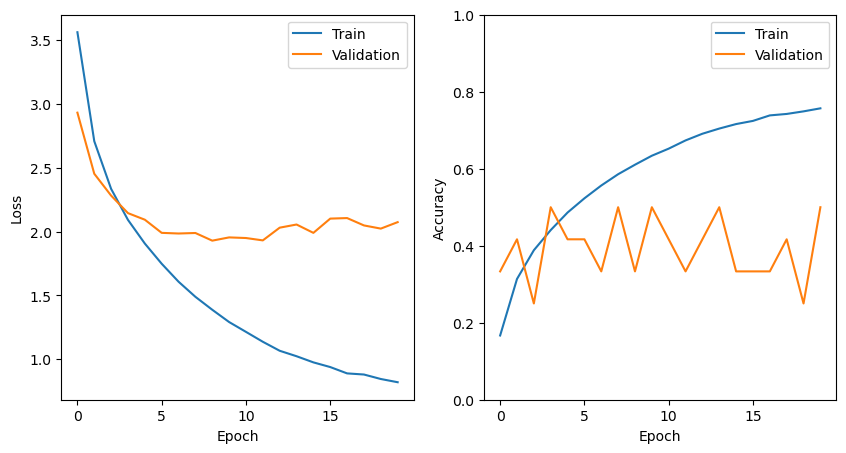

In [408]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train")
plt.plot(validation_accs, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [409]:
torch.save(model.state_dict(), "model.pth")

In [410]:
model.load_state_dict(torch.load("model.pth"))

/tmp/ipykernel_45439/1722216506.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


<All keys matched successfully>

In [411]:
def predict(model, dataloader):
    model.eval()  # 평가 모드로 전환
    all_preds = []

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, _ in dataloader:
            data = data.to(device)  # 데이터를 장치로 이동
            
            # 모델 예측
            outputs = model(data)
            preds = outputs.argmax(dim=1)
            
            # 예측값을 리스트에 추가
            all_preds.extend(preds.cpu().numpy())

    return all_preds

In [412]:
preds = predict(model, test_dataloader)

In [349]:
confusion_matrix(test_y, preds)

array([[57,  2,  0, ...,  0,  0,  0],
       [ 1, 48,  0, ...,  0,  0,  0],
       [ 4,  1, 19, ...,  0,  4,  1],
       ...,
       [ 0,  0,  0, ..., 29,  0,  0],
       [ 1,  0,  2, ...,  0, 17,  0],
       [ 0,  0,  0, ...,  0,  0, 28]])

In [350]:
classification_report(test_y, preds)

'              precision    recall  f1-score   support\n\n           0       0.74      0.70      0.72        82\n           1       0.49      0.64      0.56        75\n           2       0.58      0.24      0.34        78\n           3       0.30      0.33      0.31        66\n           4       0.23      0.25      0.24        69\n           5       0.45      0.50      0.47        66\n           6       0.64      0.46      0.54        78\n           7       0.57      0.46      0.51        79\n           8       0.77      0.60      0.67        67\n           9       0.72      0.42      0.53        67\n          10       0.41      0.33      0.37        81\n          11       0.24      0.35      0.28        72\n          12       0.62      0.33      0.43        86\n          13       0.51      0.45      0.48        65\n          14       0.20      0.69      0.32        62\n          15       0.55      0.42      0.48        71\n          16       0.36      0.38      0.37        74\n       

In [415]:
accuracy_score(test_y, preds)

0.49906666666666666

In [202]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(f1_score(test_y, preds, average="macro"))
print(precision_score(test_y, preds, average="macro"))
print(recall_score(test_y, preds, average="macro"))

0.01084120679240383
0.010949633625307436
0.011131915531651944
